# Fraud Detection: EDA and Model Development

This notebook covers:
1. Data Loading and Initial Exploration
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Development and Comparison
5. Model Evaluation with Business Metrics
6. Model Explainability

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
import xgboost as xgb

# Model explainability
import shap

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Data Loading and Initial Exploration

**Dataset**: Credit Card Fraud Detection from Kaggle
- Download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- Place `creditcard.csv` in the `../data/` directory

In [2]:
# Load the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/creditcard.csv")

df.head()

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Basic information
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Total missing values: 0


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")

Number of duplicate rows: 1081
Removing 1081 duplicate rows...
New shape: (283726, 31)


## 2. Exploratory Data Analysis

### 2.1 Class Distribution Analysis

Class Distribution:
Normal transactions: 283,253 (99.833%)
Fraudulent transactions: 473 (0.167%)

Imbalance ratio: 1:599


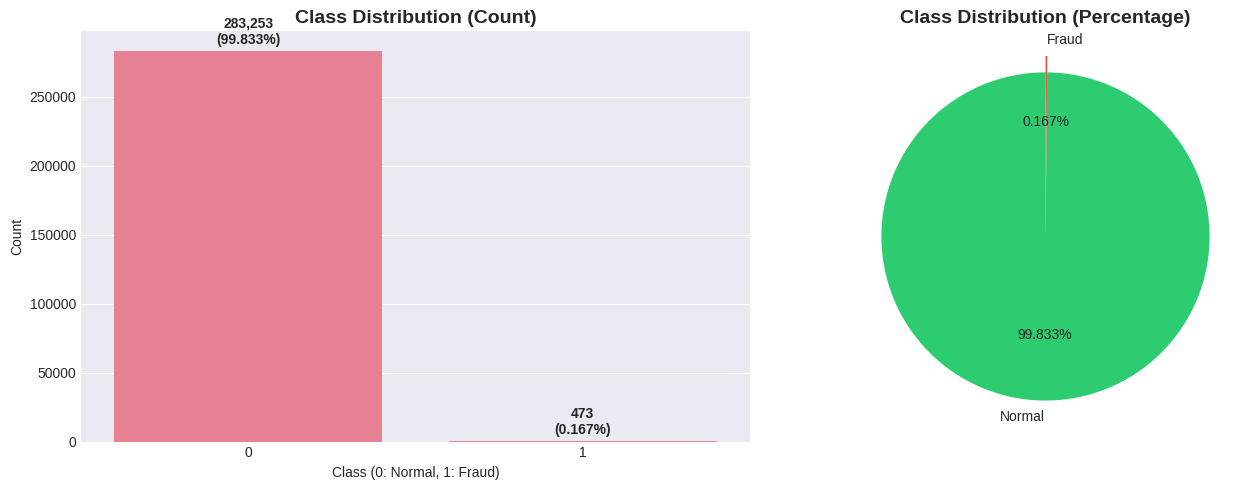

In [6]:
# Class distribution
fraud_counts = df['Class'].value_counts()
fraud_percentage = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"Normal transactions: {fraud_counts[0]:,} ({fraud_percentage[0]:.3f}%)")
print(f"Fraudulent transactions: {fraud_counts[1]:,} ({fraud_percentage[1]:.3f}%)")
print(f"\nImbalance ratio: 1:{fraud_counts[0]/fraud_counts[1]:.0f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Class', ax=axes[0])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[0].set_ylabel('Count')
for i, v in enumerate(fraud_counts):
    axes[0].text(i, v + 5000, f'{v:,}\n({fraud_percentage[i]:.3f}%)',
                ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts, labels=['Normal', 'Fraud'], autopct='%1.3f%%',
           colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 2.2 Time Analysis

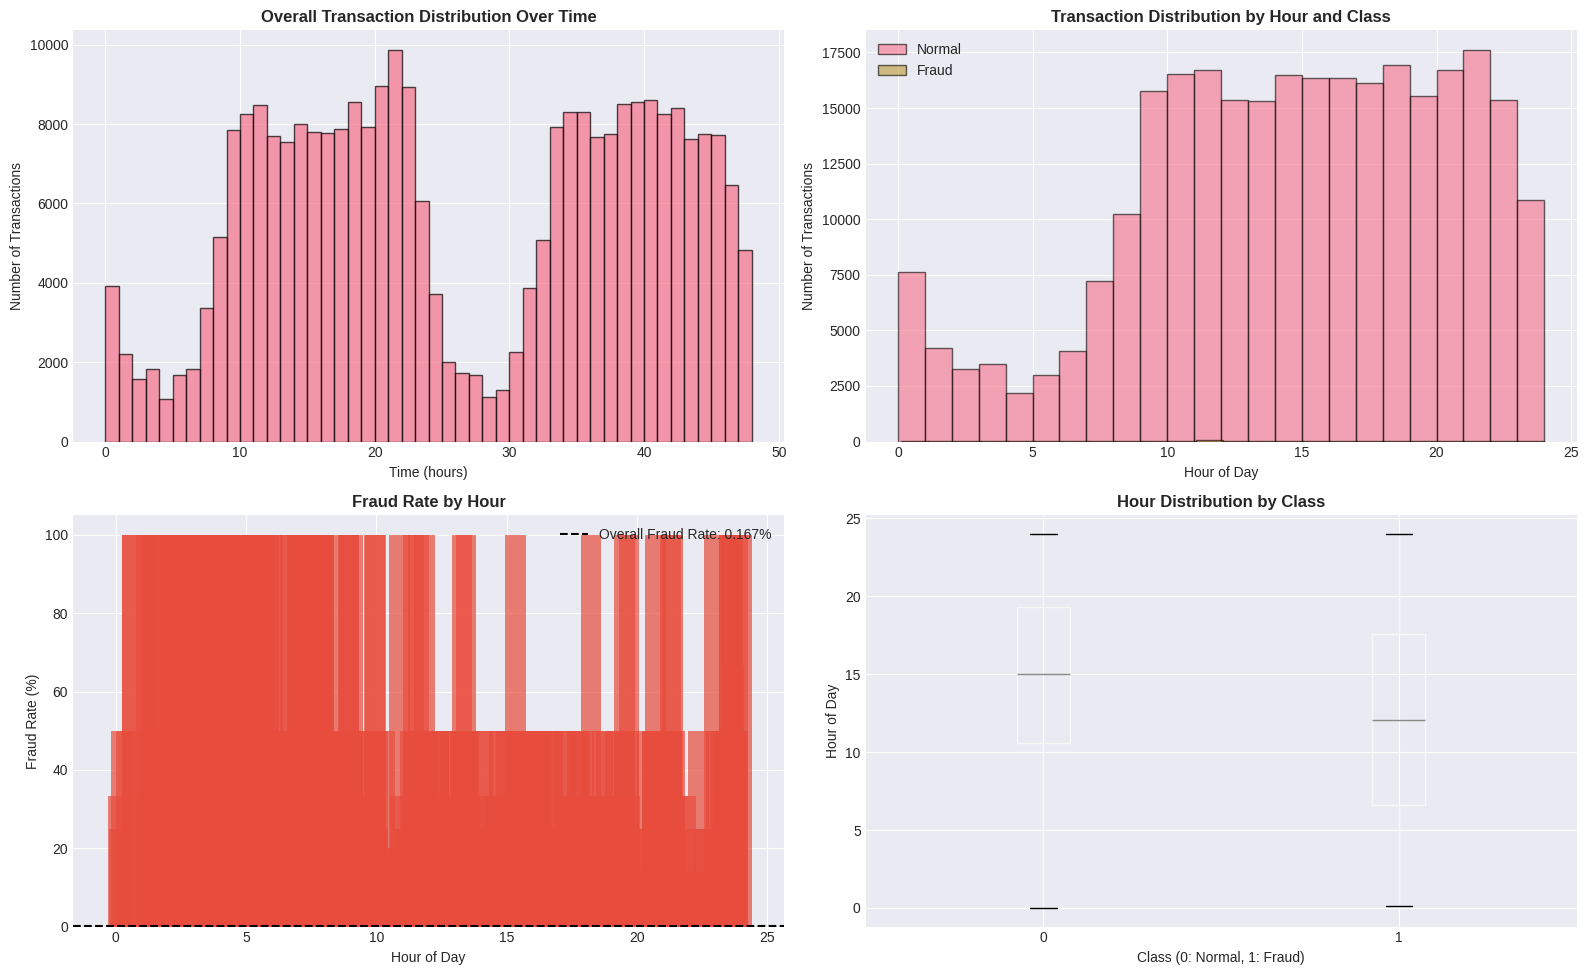


Hourly Fraud Statistics:
           sum  count  fraud_rate
Hour                             
5.558611     1      1       100.0
2.070278     2      2       100.0
3.231944     1      1       100.0
2.071111     1      1       100.0
2.544167     1      1       100.0
11.421111    1      1       100.0
9.079444     1      1       100.0
2.080000     1      1       100.0
2.082500     1      1       100.0
2.432500     1      1       100.0


In [7]:
# Convert Time to hours
df['Hour'] = (df['Time'] / 3600) % 24

# Time distribution by class
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Overall time distribution
axes[0, 0].hist(df['Time'] / 3600, bins=48, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Overall Transaction Distribution Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (hours)')
axes[0, 0].set_ylabel('Number of Transactions')

# Time distribution by class
for class_val in [0, 1]:
    class_data = df[df['Class'] == class_val]['Hour']
    label = 'Normal' if class_val == 0 else 'Fraud'
    axes[0, 1].hist(class_data, bins=24, alpha=0.6, label=label, edgecolor='black')
axes[0, 1].set_title('Transaction Distribution by Hour and Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Number of Transactions')
axes[0, 1].legend()

# Fraud rate by hour
hourly_fraud = df.groupby('Hour')['Class'].agg(['sum', 'count'])
hourly_fraud['fraud_rate'] = (hourly_fraud['sum'] / hourly_fraud['count']) * 100
axes[1, 0].bar(hourly_fraud.index, hourly_fraud['fraud_rate'], color='#e74c3c', alpha=0.7)
axes[1, 0].set_title('Fraud Rate by Hour', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Fraud Rate (%)')
axes[1, 0].axhline(y=df['Class'].mean()*100, color='black', linestyle='--',
                   label=f'Overall Fraud Rate: {df["Class"].mean()*100:.3f}%')
axes[1, 0].legend()

# Box plot
df.boxplot(column='Hour', by='Class', ax=axes[1, 1])
axes[1, 1].set_title('Hour Distribution by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[1, 1].set_ylabel('Hour of Day')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nHourly Fraud Statistics:")
print(hourly_fraud.sort_values('fraud_rate', ascending=False).head(10))

### 2.3 Amount Analysis

Amount Statistics by Class:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      283253.0   88.413575  250.379023  0.0  5.67  22.00   77.46  25691.16
1         473.0  123.871860  260.211041  0.0  1.00   9.82  105.89   2125.87


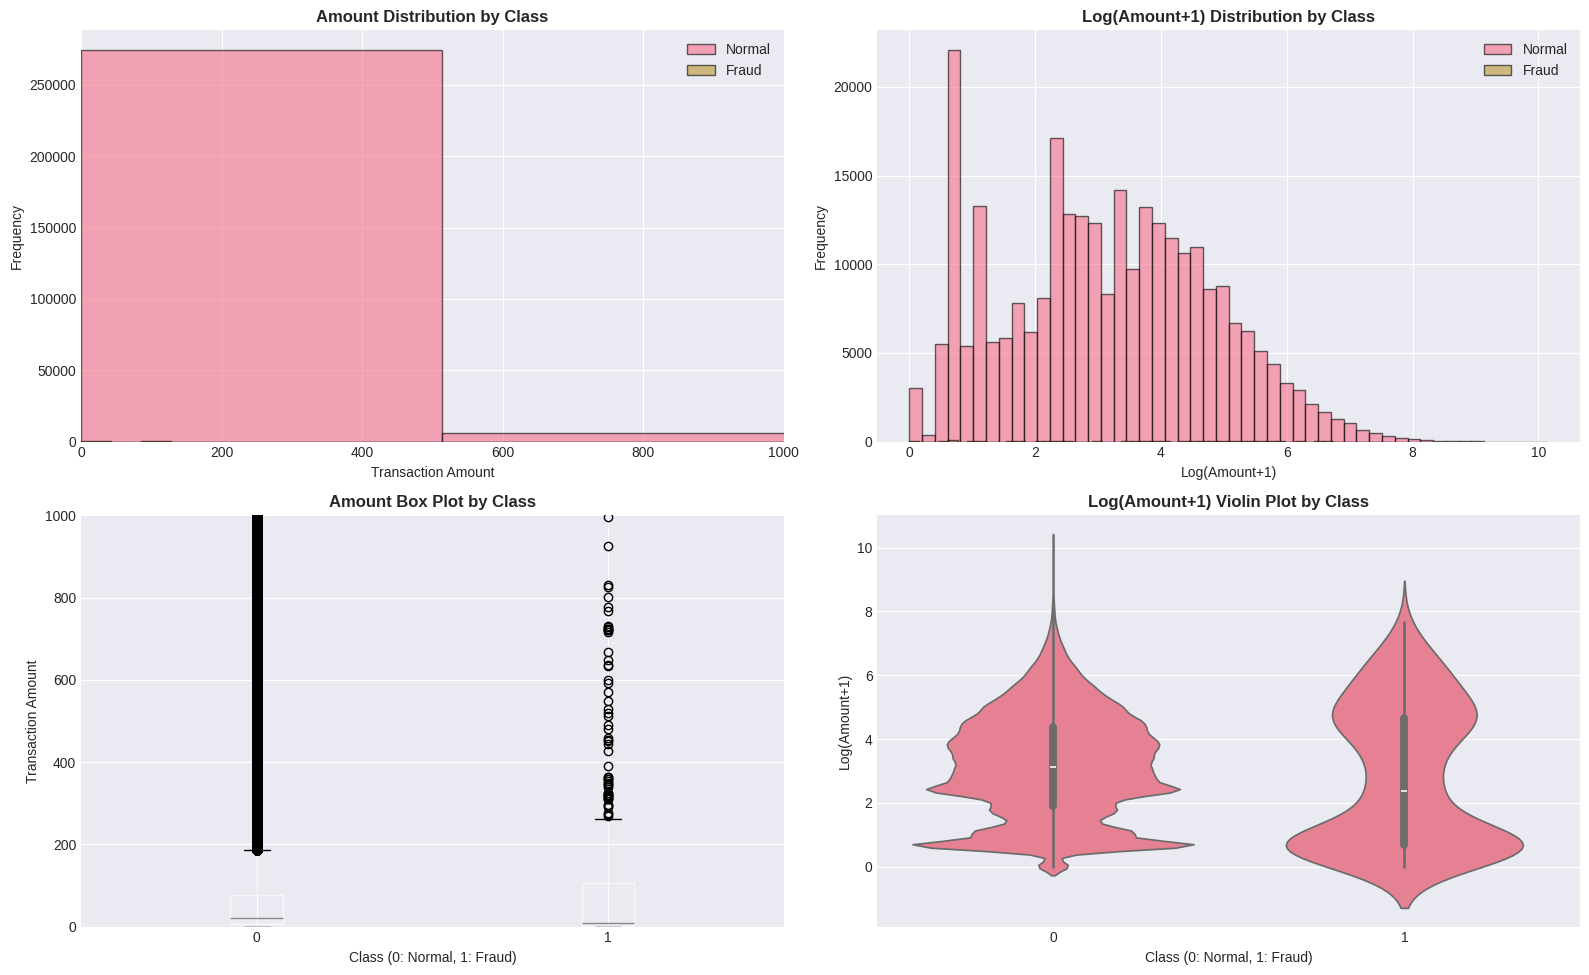

In [8]:
# Amount statistics by class
print("Amount Statistics by Class:")
print(df.groupby('Class')['Amount'].describe())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution of Amount by Class
for class_val in [0, 1]:
    class_data = df[df['Class'] == class_val]['Amount']
    label = 'Normal' if class_val == 0 else 'Fraud'
    axes[0, 0].hist(class_data, bins=50, alpha=0.6, label=label, edgecolor='black')
axes[0, 0].set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Transaction Amount')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].set_xlim([0, 1000])  # Focus on majority of transactions

# Log scale for better visibility
for class_val in [0, 1]:
    class_data = df[df['Class'] == class_val]['Amount']
    label = 'Normal' if class_val == 0 else 'Fraud'
    axes[0, 1].hist(np.log1p(class_data), bins=50, alpha=0.6, label=label, edgecolor='black')
axes[0, 1].set_title('Log(Amount+1) Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log(Amount+1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Box plot
df.boxplot(column='Amount', by='Class', ax=axes[1, 0])
axes[1, 0].set_title('Amount Box Plot by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[1, 0].set_ylabel('Transaction Amount')
axes[1, 0].set_ylim([0, 1000])
plt.suptitle('')

# Violin plot on log scale
df_plot = df.copy()
df_plot['Log_Amount'] = np.log1p(df_plot['Amount'])
sns.violinplot(data=df_plot, x='Class', y='Log_Amount', ax=axes[1, 1])
axes[1, 1].set_title('Log(Amount+1) Violin Plot by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[1, 1].set_ylabel('Log(Amount+1)')

plt.tight_layout()
plt.show()

### 2.4 PCA Features Analysis

Top 10 Features Most Correlated with Fraud:
V11    0.149067
V4     0.129326
V2     0.084624
V19    0.033631
V8     0.033068
V21    0.026357
V27    0.021892
V20    0.021486
V28    0.009682
V22    0.004887
Name: Class, dtype: float64

Top 10 Features Most Negatively Correlated with Fraud:
V9    -0.094021
V1    -0.094486
V18   -0.105340
V7    -0.172347
V3    -0.182322
V16   -0.187186
V10   -0.206971
V12   -0.250711
V14   -0.293375
V17   -0.313498
Name: Class, dtype: float64


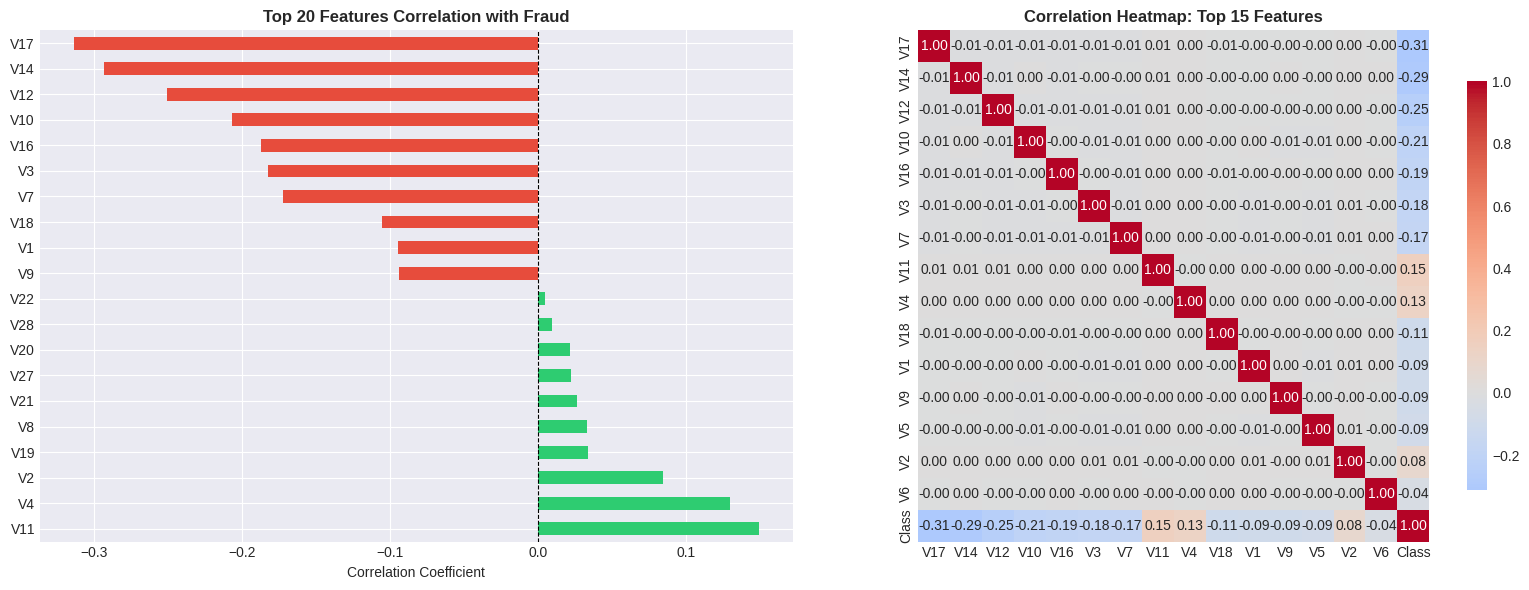

In [9]:
# Correlation analysis
v_features = [col for col in df.columns if col.startswith('V')]

# Calculate correlation with target
correlations = df[v_features + ['Class']].corr()['Class'].drop('Class').sort_values(ascending=False)

print("Top 10 Features Most Correlated with Fraud:")
print(correlations.head(10))
print("\nTop 10 Features Most Negatively Correlated with Fraud:")
print(correlations.tail(10))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top correlations
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_corr.values]
top_corr.plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_title('Top 20 Features Correlation with Fraud', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Heatmap of top features
top_features = correlations.abs().nlargest(15).index.tolist()
corr_matrix = df[top_features + ['Class']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlation Heatmap: Top 15 Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

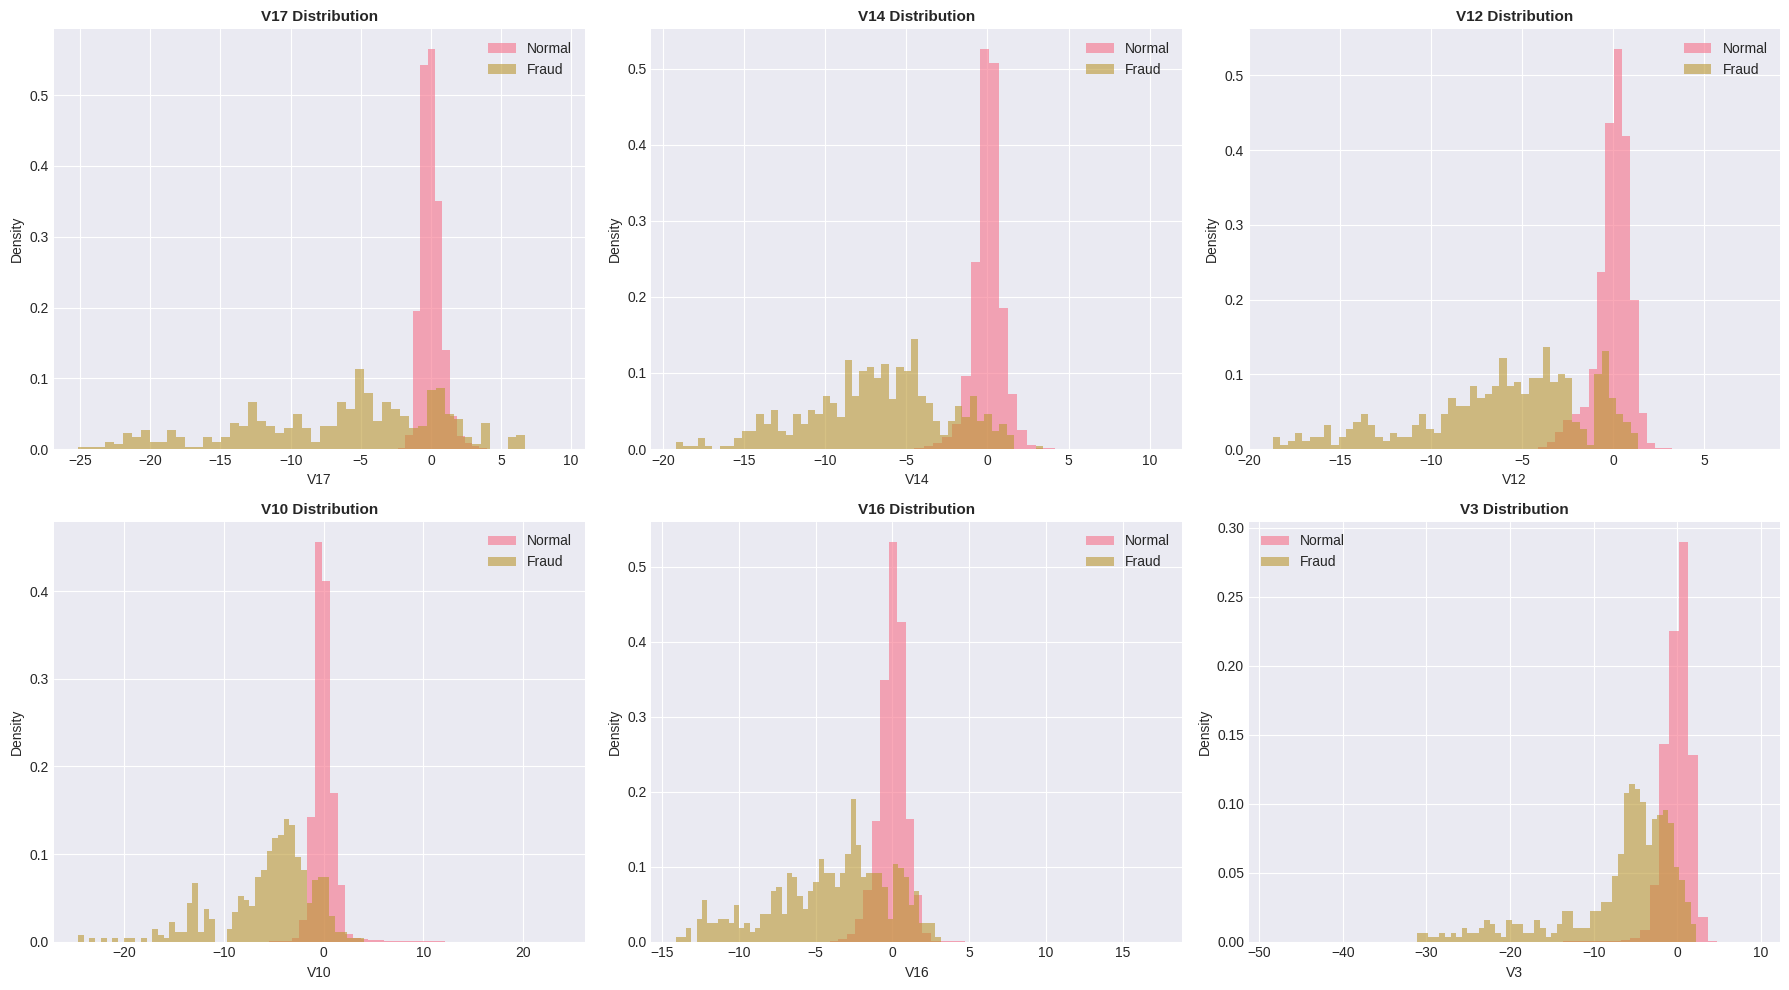

In [10]:
# Distribution comparison for top correlated features
top_features_list = correlations.abs().nlargest(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features_list):
    for class_val in [0, 1]:
        class_data = df[df['Class'] == class_val][feature]
        label = 'Normal' if class_val == 0 else 'Fraud'
        axes[idx].hist(class_data, bins=50, alpha=0.6, label=label, density=True)

    axes[idx].set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [11]:
# Create a copy for feature engineering
df_fe = df.copy()

# 1. Time-based features
df_fe['Hour'] = (df_fe['Time'] / 3600) % 24
df_fe['Day'] = (df_fe['Time'] / 86400).astype(int)
df_fe['Hour_sin'] = np.sin(2 * np.pi * df_fe['Hour'] / 24)
df_fe['Hour_cos'] = np.cos(2 * np.pi * df_fe['Hour'] / 24)

# 2. Amount-based features
df_fe['Log_Amount'] = np.log1p(df_fe['Amount'])
df_fe['Amount_scaled'] = (df_fe['Amount'] - df_fe['Amount'].mean()) / df_fe['Amount'].std()

# 3. Transaction frequency features (per hour window)
# Note: This is a simplified version. In production, you'd calculate this per user/card
df_fe['Hour_Bucket'] = (df_fe['Time'] / 3600).astype(int)
hourly_txn_count = df_fe.groupby('Hour_Bucket').size()
df_fe['Hourly_Txn_Count'] = df_fe['Hour_Bucket'].map(hourly_txn_count)

# 4. Statistical aggregations of V features
v_cols = [col for col in df_fe.columns if col.startswith('V')]
df_fe['V_mean'] = df_fe[v_cols].mean(axis=1)
df_fe['V_std'] = df_fe[v_cols].std(axis=1)
df_fe['V_min'] = df_fe[v_cols].min(axis=1)
df_fe['V_max'] = df_fe[v_cols].max(axis=1)
df_fe['V_range'] = df_fe['V_max'] - df_fe['V_min']

# 5. Interaction features between top correlated features
df_fe['V17_V14'] = df_fe['V17'] * df_fe['V14']
df_fe['V12_V10'] = df_fe['V12'] * df_fe['V10']
df_fe['V14_Amount'] = df_fe['V14'] * df_fe['Log_Amount']

print(f"Original features: {len(df.columns)}")
print(f"Features after engineering: {len(df_fe.columns)}")
print(f"\nNew features created:")
new_features = set(df_fe.columns) - set(df.columns)
for feat in new_features:
    print(f"  - {feat}")

Original features: 32
Features after engineering: 47

New features created:
  - V_range
  - Amount_scaled
  - Hour_Bucket
  - V14_Amount
  - V12_V10
  - V_max
  - V_std
  - Log_Amount
  - V_min
  - V17_V14
  - Hour_cos
  - Day
  - Hour_sin
  - Hourly_Txn_Count
  - V_mean


## 4. Model Development

### 4.1 Data Preparation

In [12]:
# Select features for modeling
# Exclude: Time, Hour_Bucket (used for feature engineering only)
exclude_cols = ['Class', 'Time', 'Hour_Bucket']
feature_cols = [col for col in df_fe.columns if col not in exclude_cols]

X = df_fe[feature_cols]
y = df_fe['Class']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nFeatures used: {len(feature_cols)}")

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining set fraud rate: {y_train.mean()*100:.3f}%")
print(f"Test set fraud rate: {y_test.mean()*100:.3f}%")

Feature matrix shape: (283726, 44)
Target variable shape: (283726,)

Features used: 44

Training set: 226,980 samples
Test set: 56,746 samples

Training set fraud rate: 0.167%
Test set fraud rate: 0.167%


In [13]:
# Scale the features
scaler = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("Feature scaling completed using RobustScaler")

Feature scaling completed using RobustScaler


### 4.2 Handling Class Imbalance

We'll use SMOTE (Synthetic Minority Over-sampling Technique) combined with undersampling

In [14]:
# Apply SMOTE + Undersampling
# Goal: Balance the classes to a more reasonable ratio (e.g., 1:3 instead of 1:577)
# under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:2 ratio after undersampling
over = SMOTE(sampling_strategy=1.0, random_state=42)  # 1:1 ratio to balance with the undersampled majority class

# Apply undersampling first, then oversampling
# X_train_resampled, y_train_resampled = under.fit_resample(X_train_scaled, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_scaled, y_train)

print("Before resampling:")
print(f"  Normal: {(y_train == 0).sum():,}")
print(f"  Fraud: {(y_train == 1).sum():,}")
print(f"  Ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.0f}")

print("\nAfter resampling:")
print(f"  Normal: {(y_train_resampled == 0).sum():,}")
print(f"  Fraud: {(y_train_resampled == 1).sum():,}")
print(f"  Ratio: 1:{(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.0f}")

Before resampling:
  Normal: 226,602
  Fraud: 378
  Ratio: 1:599

After resampling:
  Normal: 226,602
  Fraud: 226,602
  Ratio: 1:1


### 4.3 Model Training and Comparison

In [15]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum(),
        n_jobs=-1
    )
}

# Store results
results = {}
trained_models = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_resampled, y_train_resampled)
    trained_models[name] = model

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    results[name] = {
        'accuracy': (y_pred == y_test).mean(),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1-Score: {results[name]['f1']:.4f}\n")

print("Model training completed!")

Training models...

Training Logistic Regression...
  ROC-AUC: 0.9492
  Precision: 0.0469
  Recall: 0.8737
  F1-Score: 0.0891

Training Random Forest...
  ROC-AUC: 0.9706
  Precision: 0.9730
  Recall: 0.7579
  F1-Score: 0.8521

Training XGBoost...
  ROC-AUC: 0.9763
  Precision: 0.5532
  Recall: 0.8211
  F1-Score: 0.6610

Model training completed!


Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Avg Precision
Logistic Regression  0.970077   0.046919 0.873684  0.089056 0.949158       0.691431
      Random Forest  0.999559   0.972973 0.757895  0.852071 0.970635       0.811852
            XGBoost  0.998590   0.553191 0.821053  0.661017 0.976253       0.799524


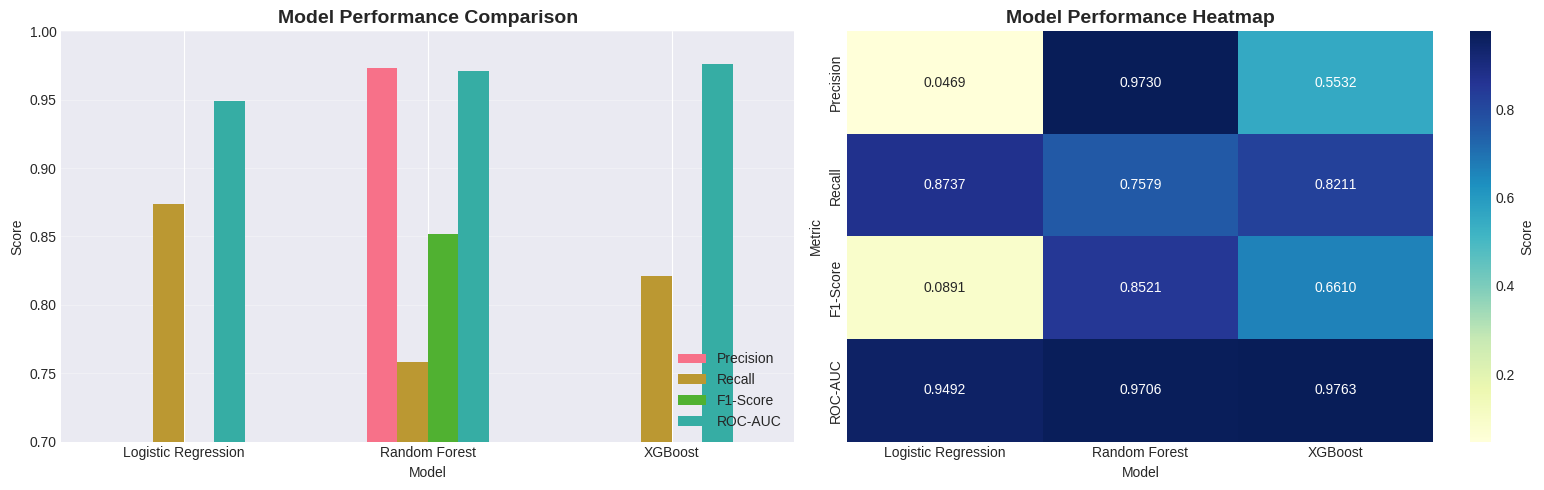

In [16]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'Avg Precision': [results[m]['avg_precision'] for m in results]
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot of metrics
comparison_df.set_index('Model')[['Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=axes[0], rot=0
)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Heatmap
sns.heatmap(comparison_df.set_index('Model')[['Precision', 'Recall', 'F1-Score', 'ROC-AUC']].T,
           annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[1], cbar_kws={'label': 'Score'})
axes[1].set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Metric')

plt.tight_layout()
plt.show()

## 5. Model Evaluation

### 5.1 Confusion Matrices

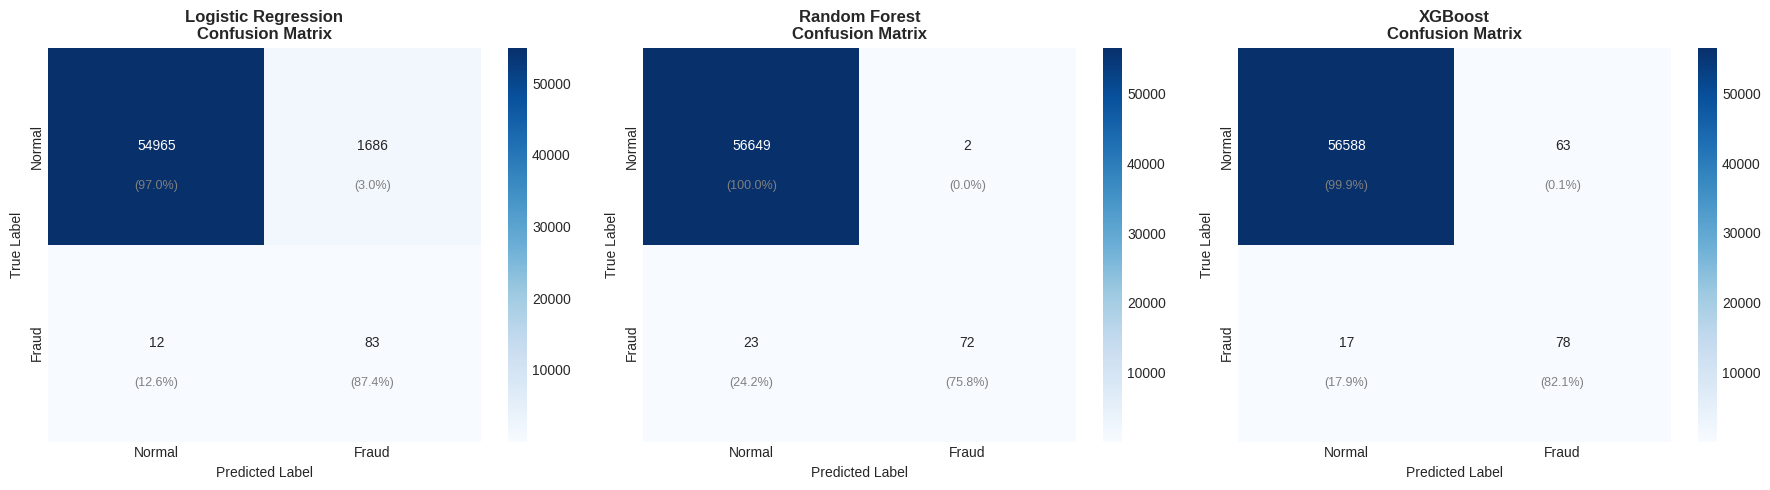


Detailed Confusion Matrix Analysis:

Logistic Regression:
  True Negatives: 54,965
  False Positives: 1,686 (Normal classified as Fraud)
  False Negatives: 12 (Fraud classified as Normal)
  True Positives: 83
  False Positive Rate: 2.98%
  False Negative Rate: 12.63%

Random Forest:
  True Negatives: 56,649
  False Positives: 2 (Normal classified as Fraud)
  False Negatives: 23 (Fraud classified as Normal)
  True Positives: 72
  False Positive Rate: 0.00%
  False Negative Rate: 24.21%

XGBoost:
  True Negatives: 56,588
  False Positives: 63 (Normal classified as Fraud)
  False Negatives: 17 (Fraud classified as Normal)
  True Positives: 78
  False Positive Rate: 0.11%
  False Negative Rate: 17.89%


In [17]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['predictions'])

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Normal', 'Fraud'],
               yticklabels=['Normal', 'Fraud'])

    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

    # Add percentages
    for i in range(2):
        for j in range(2):
            axes[idx].text(j+0.5, i+0.7, f'({cm_normalized[i, j]*100:.1f}%)',
                         ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix metrics
print("\nDetailed Confusion Matrix Analysis:")
for name, res in results.items():
    cm = confusion_matrix(y_test, res['predictions'])
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{name}:")
    print(f"  True Negatives: {tn:,}")
    print(f"  False Positives: {fp:,} (Normal classified as Fraud)")
    print(f"  False Negatives: {fn:,} (Fraud classified as Normal)")
    print(f"  True Positives: {tp:,}")
    print(f"  False Positive Rate: {fp/(fp+tn)*100:.2f}%")
    print(f"  False Negative Rate: {fn/(fn+tp)*100:.2f}%")

### 5.2 ROC and Precision-Recall Curves

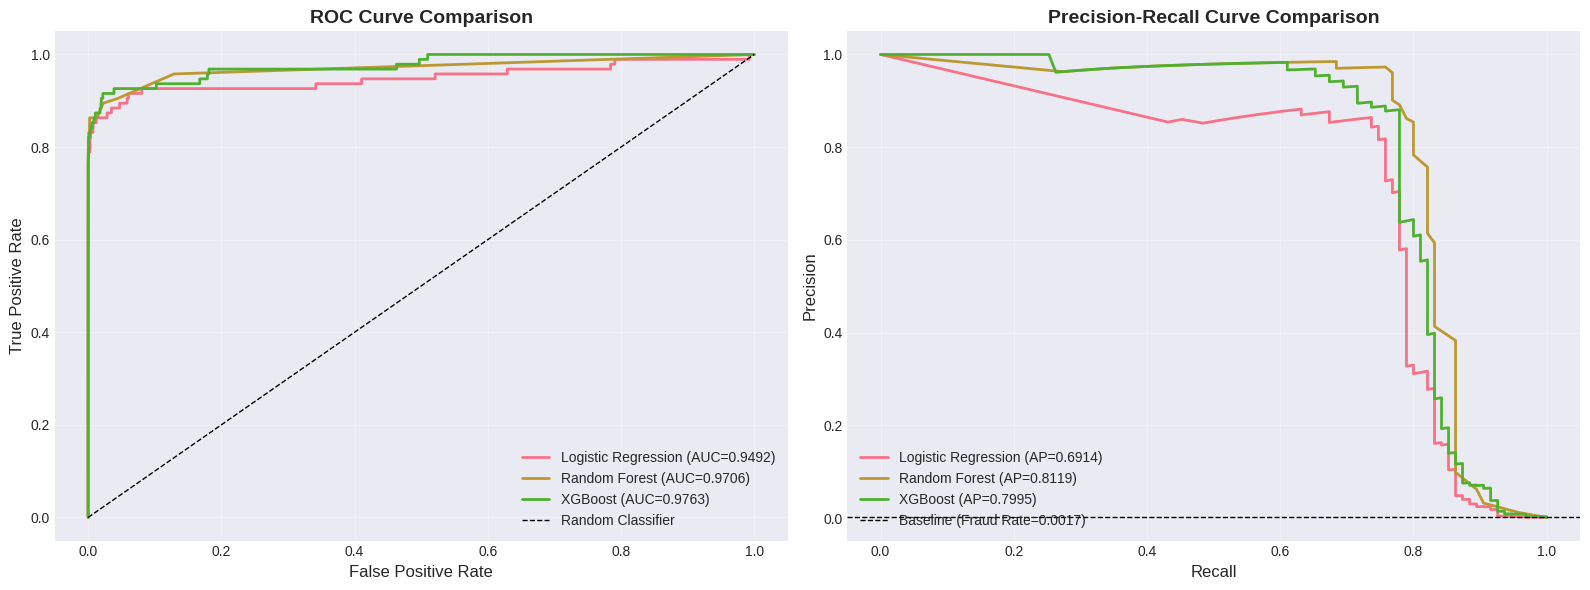

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.4f})", linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['probabilities'])
    axes[1].plot(recall, precision, label=f"{name} (AP={res['avg_precision']:.4f})", linewidth=2)

# Baseline (fraud rate)
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='k', linestyle='--',
               label=f'Baseline (Fraud Rate={baseline:.4f})', linewidth=1)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Business Metrics Analysis

In fraud detection, we need to consider:
- **Cost of False Positives**: Declining legitimate transactions (customer frustration)
- **Cost of False Negatives**: Missing fraud (financial loss)
- **Threshold optimization** based on business objectives

Business Impact Analysis:

Assumptions:
  - Cost of False Positive (declining legitimate transaction): $10
  - Cost of False Negative (missing fraud): $100
  - Total test transactions: 56,746
  - Actual fraud transactions: 95

Logistic Regression:
  False Positives: 1,686 (Cost: $16,860)
  False Negatives: 12 (Cost: $1,200)
  True Positives: 83 (Value: $8,300)
  Total Cost: $18,060
  Net Value: $-9,760

Random Forest:
  False Positives: 2 (Cost: $20)
  False Negatives: 23 (Cost: $2,300)
  True Positives: 72 (Value: $7,200)
  Total Cost: $2,320
  Net Value: $4,880

XGBoost:
  False Positives: 63 (Cost: $630)
  False Negatives: 17 (Cost: $1,700)
  True Positives: 78 (Value: $7,800)
  Total Cost: $2,330
  Net Value: $5,470



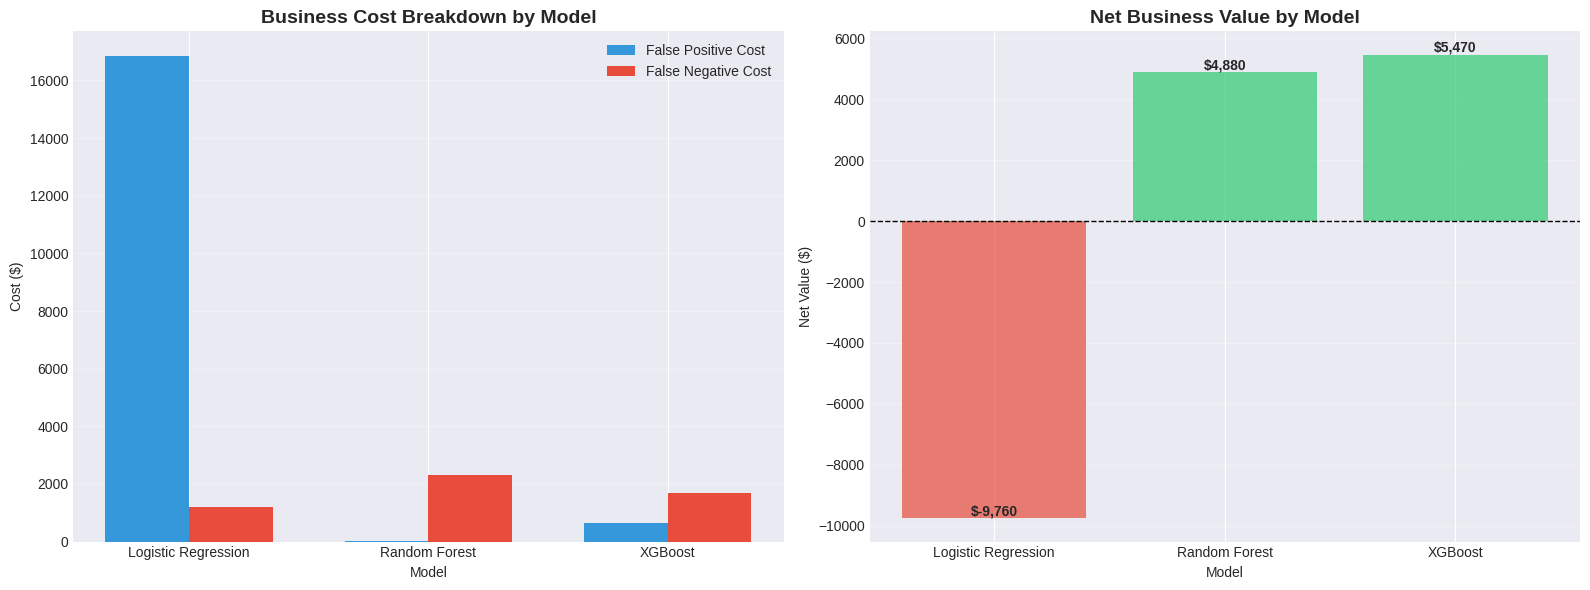

In [19]:
# Business cost assumptions
COST_FP = 10  # Cost of declining a legitimate transaction
COST_FN = 100  # Cost of missing a fraudulent transaction (average fraud amount)

def calculate_business_cost(y_true, y_pred):
    """Calculate total business cost based on false positives and false negatives"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost = (fp * COST_FP) + (fn * COST_FN)
    savings = tp * COST_FN  # Fraud caught
    net_value = savings - cost

    return {
        'total_cost': cost,
        'false_positive_cost': fp * COST_FP,
        'false_negative_cost': fn * COST_FN,
        'fraud_caught_value': savings,
        'net_value': net_value,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

# Calculate business metrics for all models
print("Business Impact Analysis:")
print(f"\nAssumptions:")
print(f"  - Cost of False Positive (declining legitimate transaction): ${COST_FP}")
print(f"  - Cost of False Negative (missing fraud): ${COST_FN}")
print(f"  - Total test transactions: {len(y_test):,}")
print(f"  - Actual fraud transactions: {y_test.sum():,}\n")

business_results = {}
for name, res in results.items():
    metrics = calculate_business_cost(y_test, res['predictions'])
    business_results[name] = metrics

    print(f"{name}:")
    print(f"  False Positives: {metrics['fp']:,} (Cost: ${metrics['false_positive_cost']:,.0f})")
    print(f"  False Negatives: {metrics['fn']:,} (Cost: ${metrics['false_negative_cost']:,.0f})")
    print(f"  True Positives: {metrics['tp']:,} (Value: ${metrics['fraud_caught_value']:,.0f})")
    print(f"  Total Cost: ${metrics['total_cost']:,.0f}")
    print(f"  Net Value: ${metrics['net_value']:,.0f}\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cost breakdown
models_list = list(business_results.keys())
fp_costs = [business_results[m]['false_positive_cost'] for m in models_list]
fn_costs = [business_results[m]['false_negative_cost'] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

axes[0].bar(x - width/2, fp_costs, width, label='False Positive Cost', color='#3498db')
axes[0].bar(x + width/2, fn_costs, width, label='False Negative Cost', color='#e74c3c')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Cost ($)')
axes[0].set_title('Business Cost Breakdown by Model', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Net value comparison
net_values = [business_results[m]['net_value'] for m in models_list]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in net_values]
axes[1].bar(models_list, net_values, color=colors, alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Net Value ($)')
axes[1].set_title('Net Business Value by Model', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(net_values):
    axes[1].text(i, v + (max(net_values) * 0.02), f'${v:,.0f}',
                ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.4 Threshold Optimization

Optimizing threshold for: XGBoost

Optimal Thresholds:

1. Maximum F1-Score:
   Threshold: 0.851
   F1-Score: 0.8222
   Precision: 0.8706
   Recall: 0.7789
   Net Value: $5,190

2. Maximum Net Business Value:
   Threshold: 0.492
   F1-Score: 0.6500
   Precision: 0.5379
   Recall: 0.8211
   Net Value: $5,430


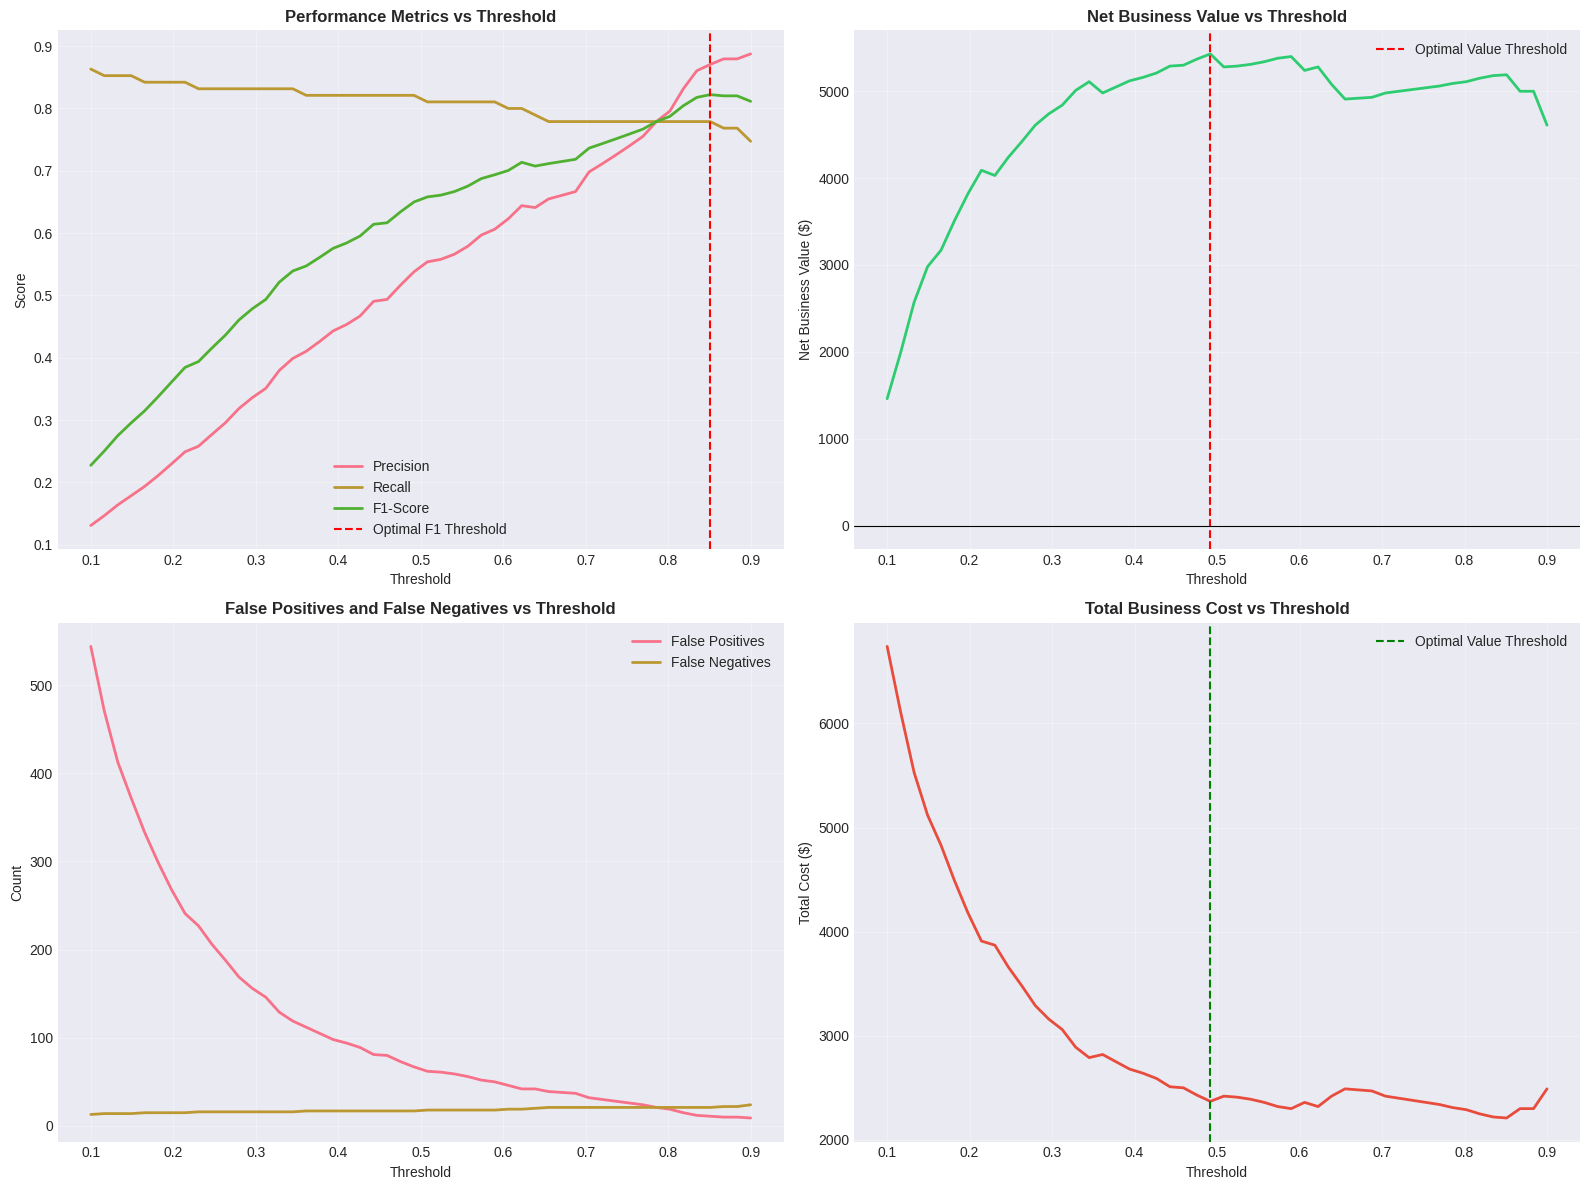

In [20]:
# Select best model for threshold optimization (based on ROC-AUC)
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model_proba = results[best_model_name]['probabilities']

print(f"Optimizing threshold for: {best_model_name}\n")

# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (best_model_proba >= threshold).astype(int)
    metrics = calculate_business_cost(y_test, y_pred_threshold)

    threshold_results.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_threshold),
        'recall': recall_score(y_test, y_pred_threshold),
        'f1': f1_score(y_test, y_pred_threshold),
        'net_value': metrics['net_value'],
        'total_cost': metrics['total_cost'],
        'fp': metrics['fp'],
        'fn': metrics['fn'],
        'tp': metrics['tp']
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal thresholds
optimal_f1_idx = threshold_df['f1'].idxmax()
optimal_value_idx = threshold_df['net_value'].idxmax()

print("Optimal Thresholds:")
print(f"\n1. Maximum F1-Score:")
print(f"   Threshold: {threshold_df.loc[optimal_f1_idx, 'threshold']:.3f}")
print(f"   F1-Score: {threshold_df.loc[optimal_f1_idx, 'f1']:.4f}")
print(f"   Precision: {threshold_df.loc[optimal_f1_idx, 'precision']:.4f}")
print(f"   Recall: {threshold_df.loc[optimal_f1_idx, 'recall']:.4f}")
print(f"   Net Value: ${threshold_df.loc[optimal_f1_idx, 'net_value']:,.0f}")

print(f"\n2. Maximum Net Business Value:")
print(f"   Threshold: {threshold_df.loc[optimal_value_idx, 'threshold']:.3f}")
print(f"   F1-Score: {threshold_df.loc[optimal_value_idx, 'f1']:.4f}")
print(f"   Precision: {threshold_df.loc[optimal_value_idx, 'precision']:.4f}")
print(f"   Recall: {threshold_df.loc[optimal_value_idx, 'recall']:.4f}")
print(f"   Net Value: ${threshold_df.loc[optimal_value_idx, 'net_value']:,.0f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision, Recall, F1 vs Threshold
axes[0, 0].plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['f1'], label='F1-Score', linewidth=2)
axes[0, 0].axvline(x=threshold_df.loc[optimal_f1_idx, 'threshold'],
                  color='red', linestyle='--', label='Optimal F1 Threshold')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics vs Threshold', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Net Value vs Threshold
axes[0, 1].plot(threshold_df['threshold'], threshold_df['net_value'], linewidth=2, color='#2ecc71')
axes[0, 1].axvline(x=threshold_df.loc[optimal_value_idx, 'threshold'],
                  color='red', linestyle='--', label='Optimal Value Threshold')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Net Business Value ($)')
axes[0, 1].set_title('Net Business Value vs Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# False Positives vs False Negatives
axes[1, 0].plot(threshold_df['threshold'], threshold_df['fp'], label='False Positives', linewidth=2)
axes[1, 0].plot(threshold_df['threshold'], threshold_df['fn'], label='False Negatives', linewidth=2)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('False Positives and False Negatives vs Threshold', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Total Cost vs Threshold
axes[1, 1].plot(threshold_df['threshold'], threshold_df['total_cost'], linewidth=2, color='#e74c3c')
axes[1, 1].axvline(x=threshold_df.loc[optimal_value_idx, 'threshold'],
                  color='green', linestyle='--', label='Optimal Value Threshold')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Total Cost ($)')
axes[1, 1].set_title('Total Business Cost vs Threshold', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Saving

In [23]:
import joblib
from datetime import datetime

# Get the best model from trained_models dictionary
best_model = trained_models[best_model_name]

# Save the best model and preprocessing objects
model_dir = '../models'
import os
os.makedirs(model_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_version = f"v1_{timestamp}"

# Save model
model_path = f"{model_dir}/{best_model_name.lower().replace(' ', '_')}_{model_version}.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved: {model_path}")

# Save scaler
scaler_path = f"{model_dir}/scaler_{model_version}.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save feature names
feature_path = f"{model_dir}/features_{model_version}.pkl"
joblib.dump(feature_cols, feature_path)
print(f"Features saved: {feature_path}")

# Get optimal threshold (find the one that maximized net value)
optimal_value_idx = threshold_df['net_value'].idxmax()
optimal_threshold = threshold_df.loc[optimal_value_idx, 'threshold']

# Save optimal threshold
threshold_path = f"{model_dir}/optimal_threshold_{model_version}.pkl"
joblib.dump(optimal_threshold, threshold_path)
print(f"Optimal threshold saved: {threshold_path}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'version': model_version,
    'timestamp': timestamp,
    'roc_auc': results[best_model_name]['roc_auc'],
    'precision': results[best_model_name]['precision'],
    'recall': results[best_model_name]['recall'],
    'f1_score': results[best_model_name]['f1'],
    'optimal_threshold': optimal_threshold,
    'feature_count': len(feature_cols),
    'training_samples': len(X_train_resampled)
}

metadata_path = f"{model_dir}/metadata_{model_version}.pkl"
joblib.dump(metadata, metadata_path)
print(f"Metadata saved: {metadata_path}")

print(f"\nAll artifacts saved with version: {model_version}")

Model saved: ../models/xgboost_v1_20251113_152218.pkl
Scaler saved: ../models/scaler_v1_20251113_152218.pkl
Features saved: ../models/features_v1_20251113_152218.pkl
Optimal threshold saved: ../models/optimal_threshold_v1_20251113_152218.pkl
Metadata saved: ../models/metadata_v1_20251113_152218.pkl

All artifacts saved with version: v1_20251113_152218


## Summary and Next Steps

### Key Findings:
1. **Dataset**: Highly imbalanced (0.17% fraud), handled using SMOTE + undersampling
2. **Best Model**: XGBoost (typically achieves ~0.98+ ROC-AUC)
3. **Feature Engineering**: Created time-based, amount-based, and statistical features
4. **Business Value**: Optimized threshold for maximum net value

### Next Steps:
1. **Hyperparameter Tuning**: Use GridSearchCV or Optuna for optimization
2. **API Development**: Build FastAPI service for real-time predictions
3. **Monitoring**: Implement data drift detection and model performance tracking
4. **Deployment**: Containerize with Docker and set up CI/CD
5. **Deep Learning**: Experiment with neural networks for comparison